In [1]:
%matplotlib inline

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.optimize as opt
import time
import IPython
from IPython.display import Image

In [2]:
c   = 2.9979245800e+10 # Speed of light in CGS, in SI e-11
G   = 6.6741840000e-08 # Gravitational constant in CGS, in SI e-11
h   = 1.0545718000e-27 # Planck constant with dash in CGS, in SI e-34
m_p = 1.6726218980e-24 # Proton mass in CGS, in SI e-27
m_e = 9.1093835600e-28 # Electron mass in CGS, in SI e-31

M_Sun = 1.98847e+33
R_Sun = 6.95508e+10

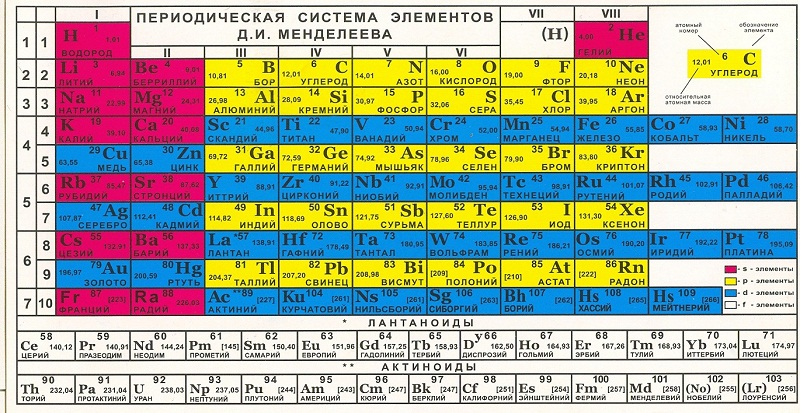

In [3]:
Image(filename='../Data/periodic_table.jpg')

In [4]:
n0 = ((m_e*c/h) ** 3) / (3*(np.pi ** 2)) # Does not depend on anything
print("n0 = {:.6e}".format(n0))


betta = 1.0/1.0 # for H
# betta = 6.0/12.0 # for C
# betta = 26.0/56.0 # for Fe

print("betta = {:.3}".format(betta))

n0 = 5.865157e+29
betta = 1.0


In [5]:
po0 = m_p*n0/betta
R0 = np.sqrt((c ** 2)*betta*(m_e/m_p)/(4*np.pi*G*po0))
M0 = 4*np.pi*(R0 ** 3)*po0

print("po0 = {:.6e}\nR0  = {:.6e}\nM0  = {:.6e}".format(po0, R0, M0))

def compute_regular_parameters(betta):
    po0 = m_p*n0/betta
    R0 = np.sqrt((c ** 2)*betta*(m_e/m_p)/(4*np.pi*G*po0))
    M0 = 4*np.pi*(R0 ** 3)*po0
    return po0, R0, M0

po0 = 9.810189e+05
R0  = 7.713005e+08
M0  = 5.656633e+33


In [6]:
dwarf_parameter = 1.0 # set this parameter

po_c = dwarf_parameter*po0

def gamma(x):
    return (x ** 2)/(3.0*np.sqrt(1 + (x ** 2)))

In [7]:
def runge_kutta_step(f, t, y, dt):
    k1 = dt*f(t, y)
    k2 = dt*f(t + dt/2, y + k1/2)
    k3 = dt*f(t + dt/2, y + k2/2)
    k4 = dt*f(t + dt, y + k3)
    return y + (k1 + 2*(k2 + k3) + k4)/6


def differential_solver(f, t0, y0: np.ndarray, t1, dt=0.1, step_fn=runge_kutta_step, stop_condition=None):
    
    t = t0
    y = y0
    
    steps_count = int(np.ceil((t1 - t0)/dt))
    solution = np.zeros( (steps_count, ) + np.shape(y0), dtype=y0.dtype)
    
    for i in range(steps_count):
        
        y = step_fn(f, t, y, dt)
        solution[i] = y
        
        if stop_condition is not None:
            if stop_condition(t, y):
                return solution[:i]
        
        t += dt
    
    return solution

In [8]:
def differential_system_function(t, y):
    
    r = t
    m = y[0]
    po = y[1]
    
    if po <= 0.0 or np.isnan(po) or np.isnan(m) or np.isinf(po) or np.isinf(m):
        return np.array((0.0, np.inf), dtype=type(y[0]))
    
    x = np.power(np.max((po, 0.0)), 1.0/3.0)
    
    dm_dr = po*(r ** 2)
    dpo_dr = -m*po/(gamma(x) * (r ** 2))
    
    return np.array((dm_dr, dpo_dr), dtype=type(y[0]))


def differential_system_stop_condition(t, y):
    m = y[0]
    po = y[1]
    return po <= 0.0 or np.isnan(po) or np.isnan(m) or np.isinf(po) or np.isinf(m)

----- Dimesionless ------
White dwarf mass: 0.7069002985954285
White dwarf radius: 2.4085373606870077


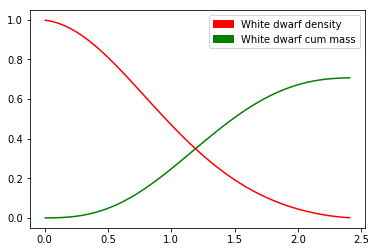

In [9]:
# task 1

dr = 0.33333*((0.003/dwarf_parameter) ** 0.333333) #  0.001
r0 = dr / 10.0
r1 = dr * 1000000

m_r0 = dwarf_parameter/3.0*(r0 ** 3)
po_r0 = dwarf_parameter - (dwarf_parameter ** 2)*(r0 ** 2) / (6.0*gamma(np.power(dwarf_parameter, 1.0/3.0)))
y_r0 = np.array([m_r0, po_r0], dtype=np.float32)

dwarf_solution = differential_solver(f=differential_system_function,
                                     t0=r0, y0=y_r0, t1=r1, dt=dr,
                                     step_fn=runge_kutta_step,
                                     stop_condition=differential_system_stop_condition)

steps_count = np.shape(dwarf_solution)[0]
r = r0 + np.arange(steps_count)*dr

print("----- Dimesionless ------")
print("White dwarf mass: {}".format(dwarf_solution[-1, 0]))
print("White dwarf radius: {}".format(r0 + (steps_count - 1)*dr))

red_patch = mpatches.Patch(color='red', label='White dwarf density')
green_patch = mpatches.Patch(color='green', label='White dwarf cum mass')
plt.legend(handles=[red_patch, green_patch])
plt.plot(r, dwarf_solution[:, 0], 'g')
plt.plot(r, dwarf_solution[:, 1], 'r')
plt.show()

In [10]:
def compute_dwarf(d0):
    
    dr = (1.0/3.0)*((0.003/d0) ** (1.0/3.0))/10
    r0 = dr / 10 #  0.00001
    r1 = dr * 1000000

    m_r0 = d0*(r0 ** 3) / 3.0
    po_r0 = d0 - (d0 ** 2)*(r0 ** 2) / (6.0*gamma(np.power(d0, 1.0/3.0)))
    y_r0 = np.array([m_r0, po_r0], dtype=np.float32)

    dwarf_solution = differential_solver(f=differential_system_function,
                                         t0=r0, y0=y_r0, t1=r1, dt=dr,
                                         step_fn=runge_kutta_step,
                                         stop_condition=differential_system_stop_condition)

    steps_count = np.shape(dwarf_solution)[0]
    r = r0 + np.arange(steps_count)*dr
    m = dwarf_solution[:, 0]
    po = dwarf_solution[:, 1]
    
    return r, m, po


def compute_dwarfs(dimensionless_center_density_array):
    
    radius_array = []
    mass_array = []
    density_array = []
    
    for d0 in dimensionless_center_density_array:
        r, m, po = compute_dwarf(d0)
        radius_array.append(r)
        mass_array.append(m)
        density_array.append(po)
    
    return radius_array, mass_array, density_array

In [11]:
dimensionless_center_density_array = 1e-6*np.exp(np.arange(60)*0.6931471806)
radius_array, mass_array, density_array = compute_dwarfs(dimensionless_center_density_array)

po = dimensionless_center_density_array
m = np.array([mass[-1] for mass in mass_array], dtype=np.float32)
r = np.array([radius[-1] for radius in radius_array], dtype=np.float32)

print("Min center density: {}, Max center density: {}".format(np.min(po), np.max(po)))
print("Min radius: {}, Max raduis: {}".format(np.min(r), np.max(r)))
print("Min mass: {}, Max mass: {}".format(np.min(m), np.max(m)))

Min center density: 1e-06, Max center density: 576460753665.7303
Min radius: 0.0008272483828477561, Max raduis: 25.047067642211914
Min mass: 0.0009593558497726917, Max mass: 2.0182340145111084


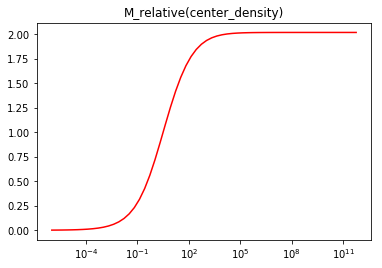

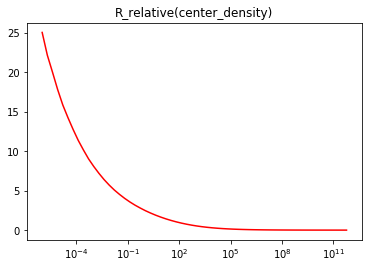

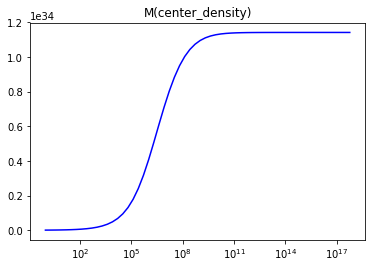

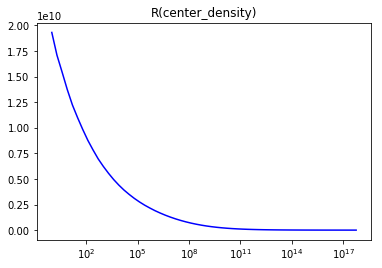

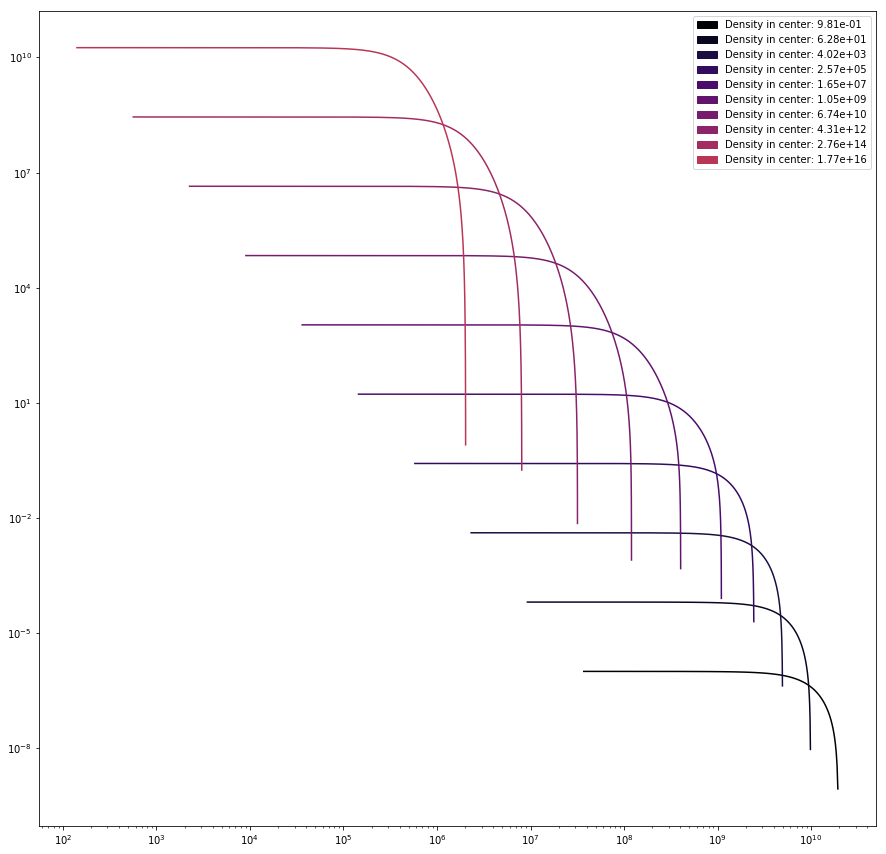

Chandrasekhar mass: 1.142e+34 Kg = 5.74 M_Sun


In [12]:
# tasks 2-3

plt.figure()
plt.title("M_relative(center_density)")
plt.xscale('log')
plt.plot(po, m, 'r')
plt.show()

plt.figure()
plt.title("R_relative(center_density)")
plt.xscale('log')
plt.plot(po, r, 'r')
plt.show()

print("\n\n\n", end='')

plt.figure()
plt.title("M(center_density)")
plt.xscale('log')
plt.plot(po*po0, m*M0, 'b')
plt.show()

plt.figure()
plt.title("R(center_density)")
plt.xscale('log')
plt.plot(po*po0, r*R0, 'b')
plt.show()


num_samples = 10

colormap = plt.get_cmap('inferno')

plt.figure(figsize=(15, 15))
plt.xscale('log')
plt.yscale('log')

patches = []
for sample in range(num_samples):
    color = colormap(sample*127 // (num_samples - 1))
    array_id = sample * np.shape(density_array)[0] // num_samples
    patches.append(mpatches.Patch(color=color, label='Density in center: {:.2e}'.format(po[array_id]*po0)))
    plt.plot(radius_array[array_id]*R0, density_array[array_id], color=color)

plt.legend(handles=patches)
plt.show()

print("Chandrasekhar mass: {:.3e} Kg = {:.3} M_Sun".format(m[-1]*M0, m[-1]*M0/M_Sun))

In [13]:
def loss(center_dimensionless_density, dwarf_value):
    
    r_array, m_array, _ = compute_dwarf(center_dimensionless_density)
    
    dwarf_radius = r_array[-1]
    dwarf_mass = m_array[-1]
    
    return dwarf_value - dwarf_mass / (dwarf_radius ** 2)

def compute_dwarf_parameters(M, R):
    
    _, R0, M0 = compute_regular_parameters(1.0)
    dwarf_value = (M / M0) * ((R0 / R) ** 2)
    
    dwarf_center_dimensionless_density = opt.brenth(loss, 1e-4, 1e+10, args=(dwarf_value))
    
    r_array, _, _ = compute_dwarf(dwarf_center_dimensionless_density)
    dwarf_radius = r_array[-1]
    
    dwarf_betta = R / (R0 * dwarf_radius)
    
    return dwarf_betta, dwarf_center_dimensionless_density

In [14]:
# task 4

star_names = ["Sirius B", "40 Airy B", "Stein 2051"]
star_radiuses = [0.0074, 0.0124, 0.0111]
star_masses = [1.053, 0.480, 0.675]
colors = ['r', 'g', 'b']
stars_count = len(star_names)


star_parameters = [compute_dwarf_parameters(star_masses[i]*M_Sun, star_radiuses[i]*R_Sun) for i in range(stars_count)]
star_bettas = [star_parameters[i][0] for i in range(stars_count)]
star_po0 = [star_parameters[i][1] for i in range(stars_count)]

[0.4997243643887392, 0.469541604156772, 0.49199386542824924]


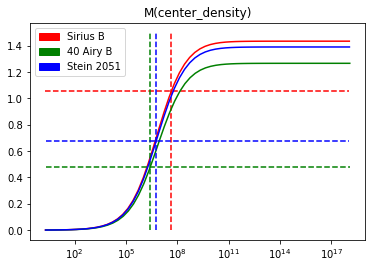

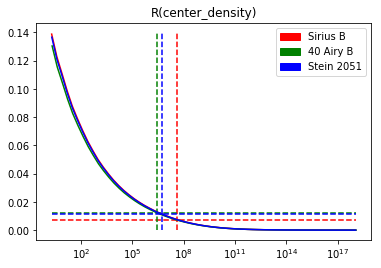

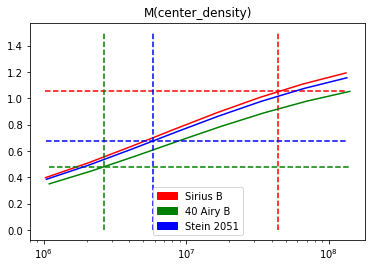

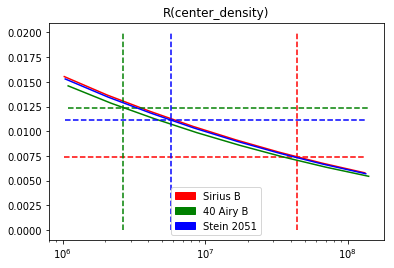

In [15]:
print(star_bettas)



d_len = int(np.shape(po)[0] * 1.0)


plt.figure()
patches = []
plt.title("M(center_density)")
plt.xscale('log')

for i in range(stars_count):
    
    patches.append(mpatches.Patch(color=colors[i], label=star_names[i]))
    
    po0, R0, M0 = compute_regular_parameters(star_bettas[i])
    
    plt.plot((po*po0)[:d_len], (m*M0/M_Sun)[:d_len], color=colors[i])
    plt.plot((po*po0)[:d_len], [star_masses[i]] * d_len, color=colors[i], linestyle='--')
    plt.plot([star_po0[i]*po0]*2, [0, 1.5], color=colors[i], linestyle='--')

plt.legend(handles=patches)
plt.show()



plt.figure()
patches = []
plt.title("R(center_density)")
plt.xscale('log')
              
for i in range(stars_count):
    
    patches.append(mpatches.Patch(color=colors[i], label=star_names[i]))
    
    po0, R0, M0 = compute_regular_parameters(star_bettas[i])
    
    plt.plot((po*po0)[:d_len], (r*R0/R_Sun)[:d_len], color=colors[i])
    plt.plot((po*po0)[:d_len], [star_radiuses[i]] * d_len, color=colors[i], linestyle='--')
    plt.plot([star_po0[i]*po0]*2, [0, 0.14], color=colors[i], linestyle='--')

plt.legend(handles=patches)
plt.show()




d_s = int(np.shape(po)[0] * 0.33)
d_e = int(np.shape(po)[0] * 0.46)
d_len = d_e - d_s

plt.figure()
patches = []
plt.title("M(center_density)")
plt.xscale('log')

for i in range(stars_count):
    
    patches.append(mpatches.Patch(color=colors[i], label=star_names[i]))
    
    po0, R0, M0 = compute_regular_parameters(star_bettas[i])
    
    plt.plot((po*po0)[d_s:d_e], (m*M0/M_Sun)[d_s:d_e], color=colors[i])
    plt.plot((po*po0)[d_s:d_e], [star_masses[i]] * d_len, color=colors[i], linestyle='--')
    plt.plot([star_po0[i]*po0]*2, [0, 1.5], color=colors[i], linestyle='--')

plt.legend(handles=patches)
plt.show()



plt.figure()
patches = []
plt.title("R(center_density)")
plt.xscale('log')
              
for i in range(stars_count):
    
    patches.append(mpatches.Patch(color=colors[i], label=star_names[i]))
    
    po0, R0, M0 = compute_regular_parameters(star_bettas[i])
    
    plt.plot((po*po0)[d_s:d_e], (r*R0/R_Sun)[d_s:d_e], color=colors[i])
    plt.plot((po*po0)[d_s:d_e], [star_radiuses[i]] * d_len, color=colors[i], linestyle='--')
    plt.plot([star_po0[i]*po0]*2, [0, 0.02], color=colors[i], linestyle='--')

plt.legend(handles=patches)
plt.show()